In [35]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from tqdm import tqdm
import random

In [3]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [4]:
def get_sparsity(tensor: torch.Tensor) -> int:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero() / tensor.numel())

def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
def rename_files(directory, suffix):
    for filename in tqdm(os.listdir(directory)):
        if os.path.isfile(os.path.join(directory, filename)):
            new_filename = filename[:-len(suffix)] + os.path.splitext(filename)[1]
            #print(new_filename)
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))

# Example usage: Replace ".txt" with ".csv" in all filenames in a directory
directory = 'F:/imagenet_1k_test/val/'  # Specify the directory path
suffix = "_n01751748.JPEG"

rename_files(directory, suffix)

100%|██████████| 50001/50001 [00:09<00:00, 5240.28it/s]


In [36]:
class CustomDataset(Dataset):
    def __init__(self, sample_rate = 0.1, transform=None):
        self.val_folder = 'F:/imagenet_1k_test/val/'
        self.val_index = 'F:/imagenet_1k_test/labels/val.txt'
        self.transform = transform

        self.images = []
        self.labels = []

        with open(self.val_index, 'r') as f:
            lines = f.readlines()
            random.shuffle(lines)
            num = len(lines)
            sample_num = int(num * sample_rate)
            print(f"sample {sample_num} images from {num} val dataset")
            for line in lines[:sample_num]:
                image_name, label = line.strip().split()
                self.images.append(self.val_folder + "/" + image_name)
                self.labels.append(int(label))

    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        label = self.labels[index]

        return image, label

    def __len__(self):
        return len(self.images)


def calculate_accuracy(model, sample_rate=0.1):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_dataset = CustomDataset(sample_rate=sample_rate, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [42]:
# use VGG19 pretrained model to inference and calculate accuracy
model = models.vgg19(pretrained=True)

accuracy = calculate_accuracy(model, sample_rate=0.03)
print(f"accuracy: {accuracy}%")

sample 1500 images from 50000 val dataset


100%|██████████| 24/24 [00:15<00:00,  1.58it/s]

accuracy: 70.93333333333334%


In [7]:
index = 1
for name, param in model.named_parameters():
    if(param.dim() > 1):
        print(f"{index}: {name}")
        index += 1

1: features.0.weight
2: features.2.weight
3: features.5.weight
4: features.7.weight
5: features.10.weight
6: features.12.weight
7: features.14.weight
8: features.16.weight
9: features.19.weight
10: features.21.weight
11: features.23.weight
12: features.25.weight
13: features.28.weight
14: features.30.weight
15: features.32.weight
16: features.34.weight
17: classifier.0.weight
18: classifier.3.weight
19: classifier.6.weight


In [10]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
            
            if(plot_index == 9):
                break
            
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

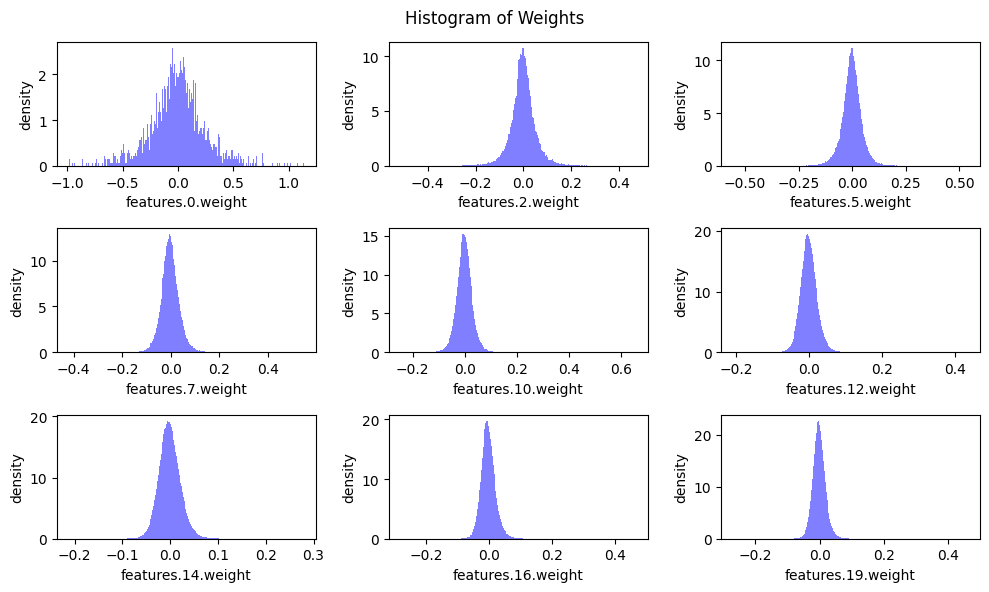

In [11]:
plot_weight_distribution(model)

In [29]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    # Step 1: calculate the #zeros (please use round())
    num_elements = tensor.numel()
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.view(-1), k=num_zeros).values
    #print(f"threshold is {threshold}")
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = torch.gt(importance, threshold)

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [30]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)
        
    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]
                
    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [43]:
@torch.no_grad()
def sensitivity_scan(model, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            #acc = evaluate(model, dataloader, verbose=False)
            acc = calculate_accuracy(model, sample_rate=0.03)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [44]:
sparsities, accuracies = sensitivity_scan(
    model, scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/19 weight - features.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 0/19 weight - features.0.weight:  17%|█▋        | 1/6 [00:16<01:24, 16.99s/it]

    sparsity=0.40: accuracy=69.53%sample 1500 images from 50000 val dataset


scanning 0/19 weight - features.0.weight:  33%|███▎      | 2/6 [00:44<01:33, 23.44s/it]

    sparsity=0.50: accuracy=67.47%sample 1500 images from 50000 val dataset


scanning 0/19 weight - features.0.weight:  50%|█████     | 3/6 [01:02<01:02, 20.97s/it]

    sparsity=0.60: accuracy=61.13%sample 1500 images from 50000 val dataset


scanning 0/19 weight - features.0.weight:  67%|██████▋   | 4/6 [01:18<00:37, 18.77s/it]

    sparsity=0.70: accuracy=57.13%sample 1500 images from 50000 val dataset


scanning 0/19 weight - features.0.weight:  83%|████████▎ | 5/6 [01:33<00:17, 17.44s/it]

    sparsity=0.80: accuracy=48.07%sample 1500 images from 50000 val dataset


scanning 0/19 weight - features.0.weight: 100%|██████████| 6/6 [01:47<00:00, 17.98s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[69.53%, 67.47%, 61.13%, 57.13%, 48.07%, 36.93%]

scanning 1/19 weight - features.2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 1/19 weight - features.2.weight:  17%|█▋        | 1/6 [00:14<01:14, 14.92s/it]

    sparsity=0.40: accuracy=69.73%sample 1500 images from 50000 val dataset


scanning 1/19 weight - features.2.weight:  33%|███▎      | 2/6 [00:29<00:59, 14.82s/it]

    sparsity=0.50: accuracy=71.67%sample 1500 images from 50000 val dataset


scanning 1/19 weight - features.2.weight:  50%|█████     | 3/6 [00:44<00:44, 14.97s/it]

    sparsity=0.60: accuracy=69.87%sample 1500 images from 50000 val dataset


scanning 1/19 weight - features.2.weight:  67%|██████▋   | 4/6 [00:59<00:29, 14.82s/it]

    sparsity=0.70: accuracy=69.20%sample 1500 images from 50000 val dataset


scanning 1/19 weight - features.2.weight:  83%|████████▎ | 5/6 [01:13<00:14, 14.68s/it]

    sparsity=0.80: accuracy=69.73%sample 1500 images from 50000 val dataset


scanning 1/19 weight - features.2.weight: 100%|██████████| 6/6 [01:28<00:00, 14.78s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[69.73%, 71.67%, 69.87%, 69.20%, 69.73%, 63.87%]

scanning 2/19 weight - features.5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 2/19 weight - features.5.weight:  17%|█▋        | 1/6 [00:14<01:12, 14.43s/it]

    sparsity=0.40: accuracy=71.47%sample 1500 images from 50000 val dataset


scanning 2/19 weight - features.5.weight:  33%|███▎      | 2/6 [00:29<00:58, 14.58s/it]

    sparsity=0.50: accuracy=70.87%sample 1500 images from 50000 val dataset


scanning 2/19 weight - features.5.weight:  50%|█████     | 3/6 [00:43<00:43, 14.50s/it]

    sparsity=0.60: accuracy=70.67%sample 1500 images from 50000 val dataset


scanning 2/19 weight - features.5.weight:  67%|██████▋   | 4/6 [00:58<00:29, 14.52s/it]

    sparsity=0.70: accuracy=66.53%sample 1500 images from 50000 val dataset


scanning 2/19 weight - features.5.weight:  83%|████████▎ | 5/6 [01:12<00:14, 14.44s/it]

    sparsity=0.80: accuracy=67.33%sample 1500 images from 50000 val dataset


scanning 2/19 weight - features.5.weight: 100%|██████████| 6/6 [01:27<00:00, 14.54s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[71.47%, 70.87%, 70.67%, 66.53%, 67.33%, 58.13%]

scanning 3/19 weight - features.7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 3/19 weight - features.7.weight:  17%|█▋        | 1/6 [00:15<01:15, 15.09s/it]

    sparsity=0.40: accuracy=71.80%sample 1500 images from 50000 val dataset


scanning 3/19 weight - features.7.weight:  33%|███▎      | 2/6 [00:29<00:58, 14.66s/it]

    sparsity=0.50: accuracy=71.67%sample 1500 images from 50000 val dataset


scanning 3/19 weight - features.7.weight:  50%|█████     | 3/6 [00:44<00:44, 14.90s/it]

    sparsity=0.60: accuracy=69.33%sample 1500 images from 50000 val dataset


scanning 3/19 weight - features.7.weight:  67%|██████▋   | 4/6 [00:59<00:29, 14.93s/it]

    sparsity=0.70: accuracy=68.07%sample 1500 images from 50000 val dataset


scanning 3/19 weight - features.7.weight:  83%|████████▎ | 5/6 [01:14<00:14, 14.78s/it]

    sparsity=0.80: accuracy=64.00%sample 1500 images from 50000 val dataset


scanning 3/19 weight - features.7.weight: 100%|██████████| 6/6 [01:29<00:00, 14.84s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[71.80%, 71.67%, 69.33%, 68.07%, 64.00%, 37.13%]

scanning 4/19 weight - features.10.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 4/19 weight - features.10.weight:  17%|█▋        | 1/6 [00:15<01:15, 15.13s/it]

    sparsity=0.40: accuracy=69.40%sample 1500 images from 50000 val dataset


scanning 4/19 weight - features.10.weight:  33%|███▎      | 2/6 [00:30<01:00, 15.02s/it]

    sparsity=0.50: accuracy=68.87%sample 1500 images from 50000 val dataset


scanning 4/19 weight - features.10.weight:  50%|█████     | 3/6 [00:44<00:44, 14.91s/it]

    sparsity=0.60: accuracy=70.67%sample 1500 images from 50000 val dataset


scanning 4/19 weight - features.10.weight:  67%|██████▋   | 4/6 [00:59<00:29, 14.96s/it]

    sparsity=0.70: accuracy=66.47%sample 1500 images from 50000 val dataset


scanning 4/19 weight - features.10.weight:  83%|████████▎ | 5/6 [01:15<00:15, 15.31s/it]

    sparsity=0.80: accuracy=62.80%sample 1500 images from 50000 val dataset


scanning 4/19 weight - features.10.weight: 100%|██████████| 6/6 [01:30<00:00, 15.10s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[69.40%, 68.87%, 70.67%, 66.47%, 62.80%, 28.73%]

scanning 5/19 weight - features.12.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 5/19 weight - features.12.weight:  17%|█▋        | 1/6 [00:16<01:20, 16.18s/it]

    sparsity=0.40: accuracy=70.40%sample 1500 images from 50000 val dataset


scanning 5/19 weight - features.12.weight:  33%|███▎      | 2/6 [00:35<01:11, 17.83s/it]

    sparsity=0.50: accuracy=69.00%sample 1500 images from 50000 val dataset


scanning 5/19 weight - features.12.weight:  50%|█████     | 3/6 [00:50<00:49, 16.49s/it]

    sparsity=0.60: accuracy=70.07%sample 1500 images from 50000 val dataset


scanning 5/19 weight - features.12.weight:  67%|██████▋   | 4/6 [01:05<00:31, 15.91s/it]

    sparsity=0.70: accuracy=68.07%sample 1500 images from 50000 val dataset


scanning 5/19 weight - features.12.weight:  83%|████████▎ | 5/6 [01:19<00:15, 15.51s/it]

    sparsity=0.80: accuracy=66.80%sample 1500 images from 50000 val dataset


scanning 5/19 weight - features.12.weight: 100%|██████████| 6/6 [01:34<00:00, 15.82s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.40%, 69.00%, 70.07%, 68.07%, 66.80%, 61.80%]

scanning 6/19 weight - features.14.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 6/19 weight - features.14.weight:  17%|█▋        | 1/6 [00:19<01:35, 19.14s/it]

    sparsity=0.40: accuracy=70.40%sample 1500 images from 50000 val dataset


scanning 6/19 weight - features.14.weight:  33%|███▎      | 2/6 [00:37<01:15, 18.81s/it]

    sparsity=0.50: accuracy=71.40%sample 1500 images from 50000 val dataset


scanning 6/19 weight - features.14.weight:  50%|█████     | 3/6 [00:55<00:54, 18.28s/it]

    sparsity=0.60: accuracy=71.13%sample 1500 images from 50000 val dataset


scanning 6/19 weight - features.14.weight:  67%|██████▋   | 4/6 [01:14<00:36, 18.42s/it]

    sparsity=0.70: accuracy=68.53%sample 1500 images from 50000 val dataset


scanning 6/19 weight - features.14.weight:  83%|████████▎ | 5/6 [01:32<00:18, 18.33s/it]

    sparsity=0.80: accuracy=68.33%sample 1500 images from 50000 val dataset


scanning 6/19 weight - features.14.weight: 100%|██████████| 6/6 [01:49<00:00, 18.23s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.40%, 71.40%, 71.13%, 68.53%, 68.33%, 63.00%]

scanning 7/19 weight - features.16.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 7/19 weight - features.16.weight:  17%|█▋        | 1/6 [00:17<01:27, 17.53s/it]

    sparsity=0.40: accuracy=69.53%sample 1500 images from 50000 val dataset


scanning 7/19 weight - features.16.weight:  33%|███▎      | 2/6 [00:34<01:08, 17.23s/it]

    sparsity=0.50: accuracy=70.20%sample 1500 images from 50000 val dataset


scanning 7/19 weight - features.16.weight:  50%|█████     | 3/6 [00:52<00:52, 17.56s/it]

    sparsity=0.60: accuracy=69.00%sample 1500 images from 50000 val dataset


scanning 7/19 weight - features.16.weight:  67%|██████▋   | 4/6 [01:10<00:35, 17.81s/it]

    sparsity=0.70: accuracy=66.27%sample 1500 images from 50000 val dataset


scanning 7/19 weight - features.16.weight:  83%|████████▎ | 5/6 [01:28<00:17, 17.77s/it]

    sparsity=0.80: accuracy=62.53%sample 1500 images from 50000 val dataset


scanning 7/19 weight - features.16.weight: 100%|██████████| 6/6 [01:50<00:00, 18.43s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[69.53%, 70.20%, 69.00%, 66.27%, 62.53%, 42.93%]

scanning 8/19 weight - features.19.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 8/19 weight - features.19.weight:  17%|█▋        | 1/6 [00:17<01:29, 17.99s/it]

    sparsity=0.40: accuracy=70.33%sample 1500 images from 50000 val dataset


scanning 8/19 weight - features.19.weight:  33%|███▎      | 2/6 [00:35<01:10, 17.64s/it]

    sparsity=0.50: accuracy=69.60%sample 1500 images from 50000 val dataset


scanning 8/19 weight - features.19.weight:  50%|█████     | 3/6 [00:52<00:52, 17.55s/it]

    sparsity=0.60: accuracy=69.80%sample 1500 images from 50000 val dataset


scanning 8/19 weight - features.19.weight:  67%|██████▋   | 4/6 [01:11<00:35, 17.82s/it]

    sparsity=0.70: accuracy=67.67%sample 1500 images from 50000 val dataset


scanning 8/19 weight - features.19.weight:  83%|████████▎ | 5/6 [01:34<00:19, 19.73s/it]

    sparsity=0.80: accuracy=64.07%sample 1500 images from 50000 val dataset


scanning 8/19 weight - features.19.weight: 100%|██████████| 6/6 [01:58<00:00, 19.72s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.33%, 69.60%, 69.80%, 67.67%, 64.07%, 49.40%]

scanning 9/19 weight - features.21.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 9/19 weight - features.21.weight:  17%|█▋        | 1/6 [00:23<01:57, 23.52s/it]

    sparsity=0.40: accuracy=71.07%sample 1500 images from 50000 val dataset


scanning 9/19 weight - features.21.weight:  33%|███▎      | 2/6 [00:46<01:32, 23.24s/it]

    sparsity=0.50: accuracy=70.93%sample 1500 images from 50000 val dataset


scanning 9/19 weight - features.21.weight:  50%|█████     | 3/6 [01:09<01:09, 23.18s/it]

    sparsity=0.60: accuracy=71.27%sample 1500 images from 50000 val dataset


scanning 9/19 weight - features.21.weight:  67%|██████▋   | 4/6 [01:33<00:46, 23.31s/it]

    sparsity=0.70: accuracy=69.27%sample 1500 images from 50000 val dataset


scanning 9/19 weight - features.21.weight:  83%|████████▎ | 5/6 [01:56<00:23, 23.20s/it]

    sparsity=0.80: accuracy=66.40%sample 1500 images from 50000 val dataset


scanning 9/19 weight - features.21.weight: 100%|██████████| 6/6 [02:19<00:00, 23.33s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[71.07%, 70.93%, 71.27%, 69.27%, 66.40%, 50.73%]

scanning 10/19 weight - features.23.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 10/19 weight - features.23.weight:  17%|█▋        | 1/6 [00:21<01:47, 21.54s/it]

    sparsity=0.40: accuracy=68.13%sample 1500 images from 50000 val dataset


scanning 10/19 weight - features.23.weight:  33%|███▎      | 2/6 [00:38<01:16, 19.06s/it]

    sparsity=0.50: accuracy=72.13%sample 1500 images from 50000 val dataset


scanning 10/19 weight - features.23.weight:  50%|█████     | 3/6 [00:56<00:54, 18.26s/it]

    sparsity=0.60: accuracy=69.33%sample 1500 images from 50000 val dataset


scanning 10/19 weight - features.23.weight:  67%|██████▋   | 4/6 [01:12<00:35, 17.68s/it]

    sparsity=0.70: accuracy=69.73%sample 1500 images from 50000 val dataset


scanning 10/19 weight - features.23.weight:  83%|████████▎ | 5/6 [01:30<00:17, 17.48s/it]

    sparsity=0.80: accuracy=66.60%sample 1500 images from 50000 val dataset


scanning 10/19 weight - features.23.weight: 100%|██████████| 6/6 [01:46<00:00, 17.69s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[68.13%, 72.13%, 69.33%, 69.73%, 66.60%, 54.07%]

scanning 11/19 weight - features.25.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 11/19 weight - features.25.weight:  17%|█▋        | 1/6 [00:15<01:15, 15.16s/it]

    sparsity=0.40: accuracy=71.87%sample 1500 images from 50000 val dataset


scanning 11/19 weight - features.25.weight:  33%|███▎      | 2/6 [00:30<01:00, 15.16s/it]

    sparsity=0.50: accuracy=68.27%sample 1500 images from 50000 val dataset


scanning 11/19 weight - features.25.weight:  50%|█████     | 3/6 [00:45<00:45, 15.13s/it]

    sparsity=0.60: accuracy=70.53%sample 1500 images from 50000 val dataset


scanning 11/19 weight - features.25.weight:  67%|██████▋   | 4/6 [01:00<00:30, 15.23s/it]

    sparsity=0.70: accuracy=68.00%sample 1500 images from 50000 val dataset


scanning 11/19 weight - features.25.weight:  83%|████████▎ | 5/6 [01:15<00:15, 15.11s/it]

    sparsity=0.80: accuracy=63.60%sample 1500 images from 50000 val dataset


scanning 11/19 weight - features.25.weight: 100%|██████████| 6/6 [01:30<00:00, 15.12s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[71.87%, 68.27%, 70.53%, 68.00%, 63.60%, 44.47%]

scanning 12/19 weight - features.28.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 12/19 weight - features.28.weight:  17%|█▋        | 1/6 [00:14<01:14, 14.83s/it]

    sparsity=0.40: accuracy=71.33%sample 1500 images from 50000 val dataset


scanning 12/19 weight - features.28.weight:  33%|███▎      | 2/6 [00:30<01:00, 15.04s/it]

    sparsity=0.50: accuracy=68.67%sample 1500 images from 50000 val dataset


scanning 12/19 weight - features.28.weight:  50%|█████     | 3/6 [00:45<00:45, 15.19s/it]

    sparsity=0.60: accuracy=70.53%sample 1500 images from 50000 val dataset


scanning 12/19 weight - features.28.weight:  67%|██████▋   | 4/6 [01:00<00:30, 15.27s/it]

    sparsity=0.70: accuracy=68.53%sample 1500 images from 50000 val dataset


scanning 12/19 weight - features.28.weight:  83%|████████▎ | 5/6 [01:15<00:15, 15.25s/it]

    sparsity=0.80: accuracy=64.27%sample 1500 images from 50000 val dataset


scanning 12/19 weight - features.28.weight: 100%|██████████| 6/6 [01:31<00:00, 15.21s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[71.33%, 68.67%, 70.53%, 68.53%, 64.27%, 48.53%]

scanning 13/19 weight - features.30.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 13/19 weight - features.30.weight:  17%|█▋        | 1/6 [00:14<01:14, 14.99s/it]

    sparsity=0.40: accuracy=70.80%sample 1500 images from 50000 val dataset


scanning 13/19 weight - features.30.weight:  33%|███▎      | 2/6 [00:29<00:59, 14.88s/it]

    sparsity=0.50: accuracy=72.33%sample 1500 images from 50000 val dataset


scanning 13/19 weight - features.30.weight:  50%|█████     | 3/6 [00:44<00:44, 14.95s/it]

    sparsity=0.60: accuracy=69.40%sample 1500 images from 50000 val dataset


scanning 13/19 weight - features.30.weight:  67%|██████▋   | 4/6 [00:59<00:30, 15.03s/it]

    sparsity=0.70: accuracy=68.33%sample 1500 images from 50000 val dataset


scanning 13/19 weight - features.30.weight:  83%|████████▎ | 5/6 [01:14<00:14, 14.94s/it]

    sparsity=0.80: accuracy=70.20%sample 1500 images from 50000 val dataset


scanning 13/19 weight - features.30.weight: 100%|██████████| 6/6 [01:29<00:00, 14.97s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.80%, 72.33%, 69.40%, 68.33%, 70.20%, 55.87%]

scanning 14/19 weight - features.32.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 14/19 weight - features.32.weight:  17%|█▋        | 1/6 [00:14<01:14, 14.93s/it]

    sparsity=0.40: accuracy=70.33%sample 1500 images from 50000 val dataset


scanning 14/19 weight - features.32.weight:  33%|███▎      | 2/6 [00:29<00:59, 14.99s/it]

    sparsity=0.50: accuracy=69.93%sample 1500 images from 50000 val dataset


scanning 14/19 weight - features.32.weight:  50%|█████     | 3/6 [00:45<00:45, 15.11s/it]

    sparsity=0.60: accuracy=70.27%sample 1500 images from 50000 val dataset


scanning 14/19 weight - features.32.weight:  67%|██████▋   | 4/6 [01:00<00:30, 15.02s/it]

    sparsity=0.70: accuracy=71.47%sample 1500 images from 50000 val dataset


scanning 14/19 weight - features.32.weight:  83%|████████▎ | 5/6 [01:15<00:15, 15.22s/it]

    sparsity=0.80: accuracy=69.27%sample 1500 images from 50000 val dataset


scanning 14/19 weight - features.32.weight: 100%|██████████| 6/6 [01:30<00:00, 15.15s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.33%, 69.93%, 70.27%, 71.47%, 69.27%, 62.27%]

scanning 15/19 weight - features.34.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 15/19 weight - features.34.weight:  17%|█▋        | 1/6 [00:15<01:15, 15.15s/it]

    sparsity=0.40: accuracy=72.40%sample 1500 images from 50000 val dataset


scanning 15/19 weight - features.34.weight:  33%|███▎      | 2/6 [00:30<01:00, 15.16s/it]

    sparsity=0.50: accuracy=70.53%sample 1500 images from 50000 val dataset


scanning 15/19 weight - features.34.weight:  50%|█████     | 3/6 [00:45<00:45, 15.17s/it]

    sparsity=0.60: accuracy=68.13%sample 1500 images from 50000 val dataset


scanning 15/19 weight - features.34.weight:  67%|██████▋   | 4/6 [01:00<00:30, 15.17s/it]

    sparsity=0.70: accuracy=68.20%sample 1500 images from 50000 val dataset


scanning 15/19 weight - features.34.weight:  83%|████████▎ | 5/6 [01:15<00:15, 15.05s/it]

    sparsity=0.80: accuracy=65.20%sample 1500 images from 50000 val dataset


scanning 15/19 weight - features.34.weight: 100%|██████████| 6/6 [01:30<00:00, 15.12s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[72.40%, 70.53%, 68.13%, 68.20%, 65.20%, 55.13%]

scanning 16/19 weight - classifier.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 16/19 weight - classifier.0.weight:  17%|█▋        | 1/6 [00:15<01:17, 15.50s/it]

    sparsity=0.40: accuracy=71.87%sample 1500 images from 50000 val dataset


scanning 16/19 weight - classifier.0.weight:  33%|███▎      | 2/6 [00:31<01:02, 15.60s/it]

    sparsity=0.50: accuracy=70.73%sample 1500 images from 50000 val dataset


scanning 16/19 weight - classifier.0.weight:  50%|█████     | 3/6 [00:46<00:46, 15.51s/it]

    sparsity=0.60: accuracy=70.13%sample 1500 images from 50000 val dataset


scanning 16/19 weight - classifier.0.weight:  67%|██████▋   | 4/6 [01:02<00:31, 15.58s/it]

    sparsity=0.70: accuracy=71.93%sample 1500 images from 50000 val dataset


scanning 16/19 weight - classifier.0.weight:  83%|████████▎ | 5/6 [01:18<00:15, 15.75s/it]

    sparsity=0.80: accuracy=70.13%sample 1500 images from 50000 val dataset


scanning 16/19 weight - classifier.0.weight: 100%|██████████| 6/6 [01:33<00:00, 15.66s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[71.87%, 70.73%, 70.13%, 71.93%, 70.13%, 67.87%]

scanning 17/19 weight - classifier.3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 17/19 weight - classifier.3.weight:  17%|█▋        | 1/6 [00:15<01:15, 15.14s/it]

    sparsity=0.40: accuracy=69.20%sample 1500 images from 50000 val dataset


scanning 17/19 weight - classifier.3.weight:  33%|███▎      | 2/6 [00:30<01:01, 15.33s/it]

    sparsity=0.50: accuracy=69.67%sample 1500 images from 50000 val dataset


scanning 17/19 weight - classifier.3.weight:  50%|█████     | 3/6 [00:46<00:46, 15.57s/it]

    sparsity=0.60: accuracy=70.33%sample 1500 images from 50000 val dataset


scanning 17/19 weight - classifier.3.weight:  67%|██████▋   | 4/6 [01:02<00:31, 15.61s/it]

    sparsity=0.70: accuracy=70.60%sample 1500 images from 50000 val dataset


scanning 17/19 weight - classifier.3.weight:  83%|████████▎ | 5/6 [01:17<00:15, 15.63s/it]

    sparsity=0.80: accuracy=68.13%sample 1500 images from 50000 val dataset


scanning 17/19 weight - classifier.3.weight: 100%|██████████| 6/6 [01:35<00:00, 15.87s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[69.20%, 69.67%, 70.33%, 70.60%, 68.13%, 70.47%]

scanning 18/19 weight - classifier.6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

sample 1500 images from 50000 val dataset


scanning 18/19 weight - classifier.6.weight:  17%|█▋        | 1/6 [00:22<01:51, 22.33s/it]

    sparsity=0.40: accuracy=70.27%sample 1500 images from 50000 val dataset


scanning 18/19 weight - classifier.6.weight:  33%|███▎      | 2/6 [00:44<01:29, 22.44s/it]

    sparsity=0.50: accuracy=71.80%sample 1500 images from 50000 val dataset


scanning 18/19 weight - classifier.6.weight:  50%|█████     | 3/6 [01:07<01:07, 22.34s/it]

    sparsity=0.60: accuracy=70.13%sample 1500 images from 50000 val dataset


scanning 18/19 weight - classifier.6.weight:  67%|██████▋   | 4/6 [01:22<00:38, 19.43s/it]

    sparsity=0.70: accuracy=70.27%sample 1500 images from 50000 val dataset


scanning 18/19 weight - classifier.6.weight:  83%|████████▎ | 5/6 [01:37<00:18, 18.04s/it]

    sparsity=0.80: accuracy=69.13%sample 1500 images from 50000 val dataset


scanning 18/19 weight - classifier.6.weight: 100%|██████████| 6/6 [01:52<00:00, 18.83s/it]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.27%, 71.80%, 70.13%, 70.27%, 69.13%, 62.07%]

In [48]:
import math
math.ceil(len(accuracies))

19

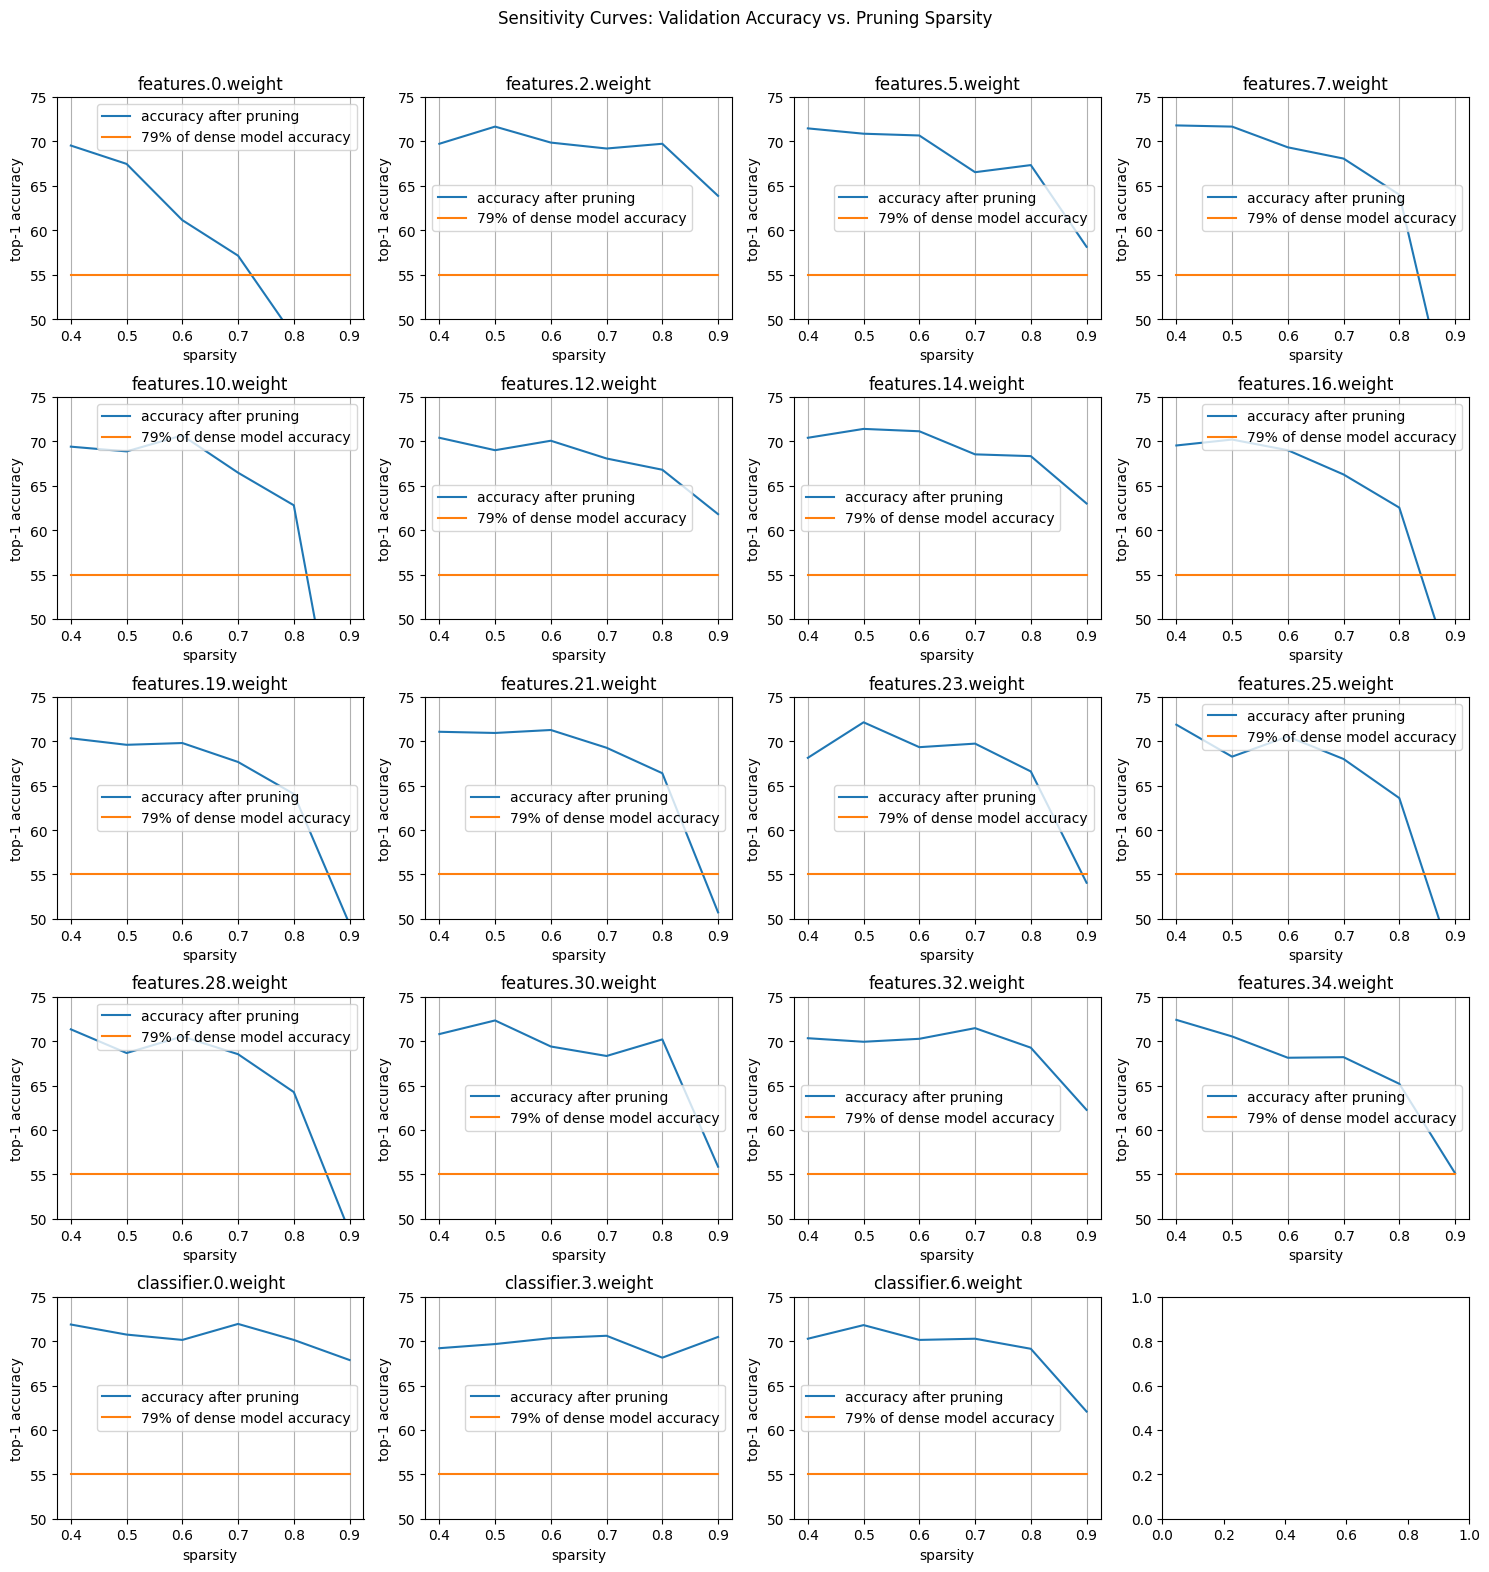

In [56]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy, begin, end):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(5, 4, figsize=(15,16))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(50, 75)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()
    
plot_sensitivity_scan(sparsities, accuracies, 70, 0, 9)

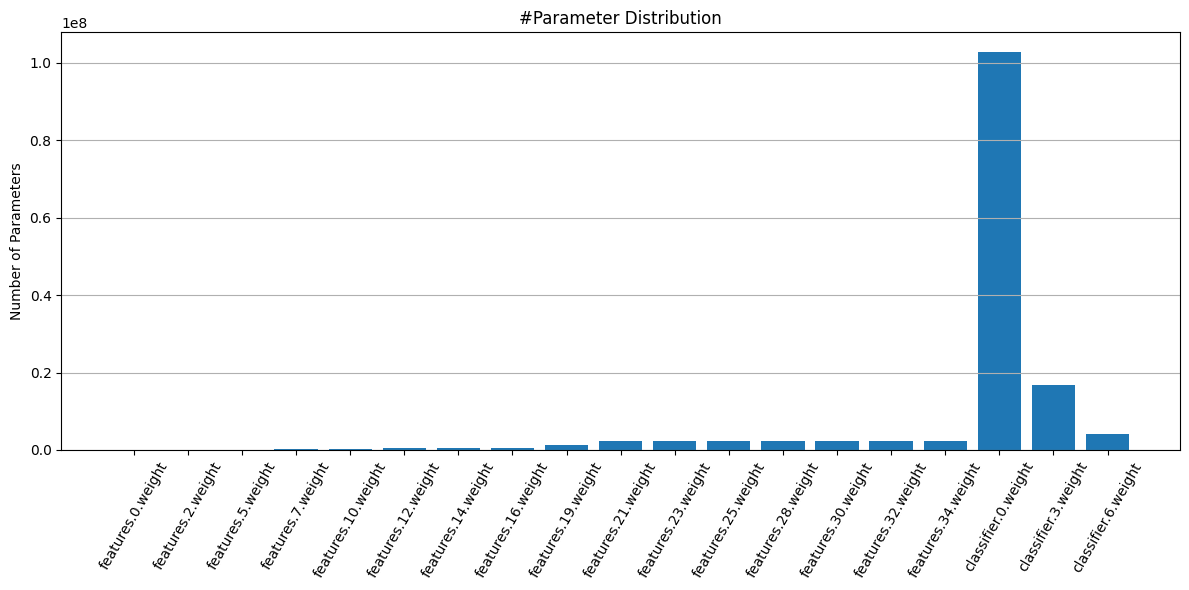

In [58]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(12, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [59]:
def recover_model():
    model = models.vgg19(pretrained=True)
    return model

In [113]:
# original

sparsity_dict = {
    'features.0.weight' : 0.4,     # 4%
    'features.2.weight' : 0.5,     # 0%
    'features.5.weight' : 0.6,     # 0%
    'features.7.weight' : 0.5,     # 0%
    'features.10.weight' : 0.6,    # 5%
    'features.12.weight' : 0.6,    # 2%
    'features.14.weight' : 0.6,    # 3%
    'features.16.weight' : 0.5,    # 0%
    'features.19.weight' : 0.6,    # 3%
    'features.21.weight' : 0.6,    # 2%
    'features.23.weight' : 0.5,    # 0%
    'features.25.weight' : 0.6,    # 2%
    'features.28.weight' : 0.6,    # 0%
    'features.30.weight' : 0.5,    # 0%
    'features.32.weight' : 0.7,    # 2%
    'features.34.weight' : 0.4,    # 1%
    'classifier.0.weight' : 0.7,
    'classifier.3.weight' : 0.7,
    'classifier.6.weight' : 0.5
}

In [140]:
sparsity_dict = {
    'features.0.weight' : 0.1,     # 4%
    'features.2.weight' : 0.5,     # 0%
    'features.5.weight' : 0.6,     # 0%
    'features.7.weight' : 0.5,     # 0%
    'features.10.weight' : 0.3,    # 5%
    'features.12.weight' : 0.3,    # 2%
    'features.14.weight' : 0.3,    # 3%
    'features.16.weight' : 0.5,    # 0%
    'features.19.weight' : 0.3,    # 3%
    'features.21.weight' : 0.3,    # 2%
    'features.23.weight' : 0.5,    # 0%
    'features.25.weight' : 0.3,    # 2%
    'features.28.weight' : 0.6,    # 0%
    'features.30.weight' : 0.5,    # 0%
    'features.32.weight' : 0.3,    # 2%
    'features.34.weight' : 0.3,    # 1%
    'classifier.0.weight' : 0.7,
    'classifier.3.weight' : 0.7,
    'classifier.6.weight' : 0.5
}

In [61]:
model = recover_model()
dense_model_accuracy = calculate_accuracy(model)
dense_model_size = get_model_size(model)

d:\Anaconda\Anaconda_setup\envs\malning\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
d:\Anaconda\Anaconda_setup\envs\malning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


sample 5000 images from 50000 val dataset


100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


In [62]:
print("dense_model_accuracy: ", dense_model_accuracy)
print("dense_model_size: ", dense_model_size)

dense_model_accuracy:  70.44
dense_model_size:  4597351680


In [142]:
model = recover_model()
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = calculate_accuracy(model, sample_rate=0.1)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

#plot_weight_distribution(model, count_nonzero_only=True)

After pruning with sparsity dictionary
  features.0.weight: 0.10
  features.2.weight: 0.50
  features.5.weight: 0.60
  features.7.weight: 0.50
  features.10.weight: 0.30
  features.12.weight: 0.30
  features.14.weight: 0.30
  features.16.weight: 0.50
  features.19.weight: 0.30
  features.21.weight: 0.30
  features.23.weight: 0.50
  features.25.weight: 0.30
  features.28.weight: 0.60
  features.30.weight: 0.50
  features.32.weight: 0.30
  features.34.weight: 0.30
  classifier.0.weight: 0.70
  classifier.3.weight: 0.70
  classifier.6.weight: 0.50
The sparsity of each layer becomes
  features.0.weight: 0.10
  features.2.weight: 0.50
  features.5.weight: 0.60
  features.7.weight: 0.50
  features.10.weight: 0.30
  features.12.weight: 0.30
  features.14.weight: 0.30
  features.16.weight: 0.50
  features.19.weight: 0.30
  features.21.weight: 0.30
  features.23.weight: 0.50
  features.25.weight: 0.30
  features.28.weight: 0.60
  features.30.weight: 0.50
  features.32.weight: 0.30
  features.34

100%|██████████| 79/79 [01:23<00:00,  1.06s/it]

Sparse model has accuracy=68.36% before fintuning
